# Inference Pipeline with Scikit-learn and Linear Learner

**Requirement**
1. Raw data should be present in S3 bucket
2. Baisc data pre-processing stpes are already known and need to be productionized

**To Do**
1. Train sklearn pre-processing model
2. Train sklearn classification model
3. Build inference pipeline
4. Deploy inference pipeline as Endpoint
5. Make prediction using Endpoint
6. Retrieve the model present in Endpoint
7. Model Interperetaion using SHAP


### Table of contents


1. fit/train a sklearn pre-processor.
It will perform preprocessing of numeric cat cols
   
 * numeric : imputation, scaling
 * categoric : imputation, one-hot-encoding
 * also perform batch transformation of train/test data to be used for ml_model training
   
   
2. train sklearn ml model (RF regressor)
 * local training of model
 * train sagemaker container

3. build up inference-ml-pipeline
 * raw_data(S3) --> [preprocessing ==> ml_model] --> prediction
    
4. deploy inference-ml-pipeline as an endpoint

5. prediction using the endpoint

6. Retrieve artifacts
 * pipeline model
 * confusion matrix
 * pr curve
 
7. model interpretation using SHAP

In [36]:
# 1. SHAP
# 2. store artifacts of sm train job

# Utils

In [3]:
def get_s3uri_df_data(s3uri=None, return_df=False, header=None):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    print(bucket_name)
    print(prefix)
    obj = s3.Object(bucket_name, prefix)
    data_stream = obj.get()["Body"].read().decode('utf-8')   
    
    if return_df:
        df = pd.read_csv(StringIO(input_data), header=header)
        return df
    
    return data_stream


def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    print(bucket_name)
    print(prefix)
    print(file_name)
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')   

In [4]:
%load_ext autoreload
%autoreload 2

import json
import io
from urllib.parse import urlparse
import boto3

import sagemaker
from sagemaker import get_execution_role

import os
import numpy as np
import pandas as pd

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

# S3 prefix
S3_BUCKET = "sklearn-pipeline"
S3_PREFIX = 'sklearn-pipeline-titanic'

S3_BUCKET, S3_PREFIX

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('sklearn-pipeline', 'sklearn-pipeline-titanic')

In [5]:
col_to_predict = "survived"

In [89]:
#!aws s3 ls s3://sklearn-pipeline

# 1. Get raw data <a class="anchor" id="training"></a>

In [6]:
SEED = 100

RAW_FILE       = 'titanic_dataset.csv'
WORK_DIRECTORY = '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir'

RAW_FILE_PATH  = "{}/raw_data/{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_TRAIN_PATH = "{}/train/train_{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_TEST_PATH  = "{}/test/test_{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_VAL_PATH   = "{}/val/val_{}".format(WORK_DIRECTORY, RAW_FILE)

PP_TRAIN_PATH = "{}/pp_train/train_{}".format(WORK_DIRECTORY, RAW_FILE)
PP_TEST_PATH  = "{}/pp_test/test_{}".format(WORK_DIRECTORY, RAW_FILE)
PP_VAL_PATH   = "{}/pp_val/val_{}".format(WORK_DIRECTORY, RAW_FILE)

ARTIFACTS_PATH = "{}/artifacts".format(WORK_DIRECTORY)

In [7]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X[col_to_predict] = y
X["user_id"] = ["user_"+str(i) for i in range(len(X))]

from pre_processing_script import COLLIST_ALL, COLLIST_FEATURE
X = X[COLLIST_ALL]

# train, test, val : 65%, 25%, 10%
train_data, test_data, val_data = np.split(X.sample(frac=1, random_state=SEED), [int(.65*len(X)), int(.9*len(X))])
val_data = val_data[COLLIST_FEATURE]

# save the data
train_data.to_csv(path_or_buf=RAW_TRAIN_PATH, index=False, header=None)
test_data.to_csv(path_or_buf=RAW_TEST_PATH, index=False, header=None)
val_data.to_csv(path_or_buf=RAW_VAL_PATH, index=False, header=None)

print("raw_data: {}, train: {}, test: {}, val: {}".format(X.shape, train_data.shape, test_data.shape, val_data.shape))
X.head(2)

raw_data: (1309, 7), train: (850, 7), test: (328, 7), val: (131, 5)


,survived,user_id,age,fare,embarked,sex,pclass
0,1,user_0,29.0000,211.3375,S,female,1.0
1,1,user_1,0.9167,151.5500,S,male,1.0


In [8]:
train_data[col_to_predict].value_counts(), test_data[col_to_predict].value_counts()

(0    526
 1    324
 Name: survived, dtype: int64,
 0    202
 1    126
 Name: survived, dtype: int64)

In [9]:
# reverify that the train/test/data are successfully created and saved
train_data.head(1)

,survived,user_id,age,fare,embarked,sex,pclass
173,0,user_173,32.5,211.5,C,male,1.0


In [15]:
# reverify that the train/test/data are successfully created and saved
temp_train_data = pd.read_csv(filepath_or_buffer=RAW_TRAIN_PATH, header=None)
temp_train_data.head(1)

,0,1,2,3,4,5,6
0,0,user_173,32.5,211.5,C,male,1.0


## Upload the data for training to S3

In [16]:
s3_input_raw_train = sagemaker_session.upload_data(
    path=RAW_TRAIN_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_train'))

s3_input_raw_test = sagemaker_session.upload_data(
    path=RAW_TEST_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_test'))

s3_input_raw_val = sagemaker_session.upload_data(
    path=RAW_VAL_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_val'))

s3_input_raw_train, s3_input_raw_test, s3_input_raw_val

('s3://sklearn-pipeline/sklearn-pipeline-titanic/data_train/train_titanic_dataset.csv',
 's3://sklearn-pipeline/sklearn-pipeline-titanic/data_test/test_titanic_dataset.csv',
 's3://sklearn-pipeline/sklearn-pipeline-titanic/data_val/val_titanic_dataset.csv')

# Data pre-processing
Now raw train/test/val data is available in S3 bucket

## local pp
1. Here we can verif the pre-processing script quickly
2. pre-processing script can be modified till we get the satishfactory results
3. all the functionalities must be verified before training the sagemaker-container pre-processing model

input_fn

model_fn

predict_fn

In [18]:
train_data_local_dir = "/".join(RAW_TRAIN_PATH.split("/")[:-1])
artifacts_local_dir  = ARTIFACTS_PATH
artifacts_local_dir, train_data_local_dir

! python pre_processing_script.py --output-data-dir /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts/ \
                                  --model-dir /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts/ \
                                  --train /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/train/

========================================_sklearn-pre-processor_========================================
extracting arguments
data loading completed:
data shape :  (850, 7)
columns : ['survived', 'user_id', 'age', 'fare', 'embarked', 'sex', 'pclass']
loaded RAW data : 
 [[0 'user_173' 32.5 211.5 'C' 'male' 1]] 

to_predict_col : [0 1] : [526 324]

before pp : FEATURE data shape :  (850, 5)
columns (5 columns): ['age', 'fare', 'embarked', 'sex', 'pclass']
sample data : 
 [[32.5 211.5 'C' 'male' 1]] 

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s

after pp : FEATURE data shape :  (850, 10)
(IMP) column (10 columns): ['age' 'fare' 'x0_C' 'x0_Q' 'x0_S' 'x1_female' 'x1_male' 'x2_1' 'x2_2'
 'x2_3']
sample data : 
 [0.23750065 3.71563628 1.         0.         0.         0.
 1.         1.         0.         0.        ]

saved model at :  /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-class

In [19]:
%reload_ext autoreload
from pre_processing_script import model_fn as pp_model_fn
from pre_processing_script import predict_fn as pp_predict_fn
from pre_processing_script import input_fn as pp_input_fn

In [20]:
#s3_data_path = s3_input_raw_train
s3_data_path = s3_input_raw_val
model_dir = artifacts_local_dir

# verify model_fn
model     = pp_model_fn(model_dir)
print(type(model))

# verify input_fn
input_data = get_s3uri_df_data(s3uri=s3_data_path, return_df=False, header=None)
df = pp_input_fn(input_data, content_type="text/csv")
print(df.shape)

<class 'sklearn.compose._column_transformer.ColumnTransformer'>
sklearn-pipeline
sklearn-pipeline-titanic/data_val/val_titanic_dataset.csv
======================================== input_fn ========================================
This pred/val data i.e unlabelled, not include col_to_predict
df.shape :  (131, 5)
(131, 5)


In [21]:
# verify predict_fn
pp_data = pp_predict_fn(input_data=df, model=model)

print(pp_data.shape)
print(type(pp_data))

======================================== predict_fn ========================================
before pp :  data shape : (131, 5)
input data type : <class 'pandas.core.frame.DataFrame'>
test/pred job
only contain the feature data
after pp : data shape : (131, 10)
sample data : 
 [-1.69835544  0.08898475  0.          0.          1.          0.
  1.          0.          1.          0.        ]
(131, 10)
<class 'numpy.ndarray'>


In [22]:
import matplotlib.pyplot as plt
from sklearn import set_config

In [23]:
#model
f = plt.figure()
set_config(display='diagram')
model

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['embarked', 'sex', 'pclass'])],
                  verbose=True)

<Figure size 432x288 with 0 Axes>

In [26]:
# once local run is succesfull, train the container based model

## setup
1. once local run is succesfull, train the sagemaker-container based model
2. pre_processing_script.py is wokring fine
3. train sklearn_preprocessor container

In [27]:
PP_SCRIPT_NAME = 'pre_processing_script.py'

# preprocessor setup
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
sklearn_preprocessor = SKLearn(
                            entry_point=PP_SCRIPT_NAME,
                            role=role,
                            framework_version=FRAMEWORK_VERSION,
                            train_instance_type="ml.c4.xlarge",
                            sagemaker_session=sagemaker_session
                            )

## train

In [28]:
sklearn_preprocessor.fit({'train': s3_input_raw_train})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-24 07:20:37 Starting - Starting the training job...
2020-09-24 07:20:39 Starting - Launching requested ML instances.........
2020-09-24 07:22:12 Starting - Preparing the instances for training......
2020-09-24 07:23:30 Downloading - Downloading input data......
2020-09-24 07:24:38 Training - Training image download completed. Training in progress..2020-09-24 07:24:38,612 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-09-24 07:24:38,614 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-24 07:24:38,624 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-24 07:25:10,486 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-24 07:25:10,499 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-24 07:25:10,510 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installe

### batch transform the raw data to train/test data
1. generate pre-processing train/test/val data
2. batch transfomred data is by default saved in the S3 bucket
3. this data is consumed by ml-estimator container

In [30]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
pp_transformer = sklearn_preprocessor.transformer(
                                                    instance_count=1, 
                                                    instance_type='ml.m5.xlarge',
                                                    assemble_with = 'Line',
                                                    accept = 'text/csv'
                                                 )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [31]:
# Preprocess training data : s3_input_raw_train
pp_transformer.transform(s3_input_raw_train, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_train = pp_transformer.output_path

Waiting for transform job: sagemaker-scikit-learn-2020-09-24-07-25-50-542
..............................
2020-09-24T07:30:37.412:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
2020-09-24 07:30:34,001 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-24 07:30:34,004 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-24 07:30:34,004 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

2020-09-24 07:30:34,001 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-24 07:30:34,004 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-24 07:30:34,004 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimi

In [32]:

# batch preprocess test data : s3_input_raw_test
pp_transformer.transform(s3_input_raw_test, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_test = pp_transformer.output_path
"""
s3_pp_test = s3_pp_train
"""

Waiting for transform job: sagemaker-scikit-learn-2020-09-24-07-31-03-605
..............................
2020-09-24T07:35:54.388:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
2020-09-24 07:35:51,475 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-24 07:35:51,477 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-24 07:35:51,478 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forward

'\ns3_pp_test = s3_pp_train\n'

In [33]:
# only useful for assessing the ml_model only endpoint
"""
# batch preprocess val data : s3_input_raw_val
pp_transformer.transform(s3_input_raw_val, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_val = pp_transformer.output_path
"""
s3_pp_val = None


In [34]:
s3_input_raw_train

's3://sklearn-pipeline/sklearn-pipeline-titanic/data_train/train_titanic_dataset.csv'

In [37]:
s3_pp_train, s3_pp_test, s3_pp_val

('s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-24-07-25-50-542',
 's3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-24-07-31-03-605',
 None)

# ML model (sklearn)
1. train sklearn classification-model locally (input data is required from local dir)
2. once model_script.py is ready, train sagemaker-container using model_script.py (input data is required from S3 uri)

## local training

In [38]:
# fetch data
s3uri     = s3_pp_train
file_name = '{}.out'.format(RAW_TRAIN_PATH.split("/")[-1])
s3_obj = get_csv_output_from_s3(s3uri, file_name)
train_df_pp  = pd.read_csv(io.StringIO(s3_obj), sep=",", header=None)

"""
s3uri     = s3_pp_test
file_name = '{}.out'.format(RAW_TEST_PATH.split("/")[-1])
s3_obj = get_csv_output_from_s3(s3uri, file_name)
test_df_pp  = pd.read_csv(io.StringIO(s3_obj), sep=",", header=None)
"""
test_df_pp = train_df_pp.copy()


train_df_pp.to_csv(path_or_buf=PP_TRAIN_PATH, index=False, header=None)
test_df_pp.to_csv(path_or_buf=PP_TEST_PATH, index=False, header=None)
#val_df_pp.to_csv(path_or_buf=PP_VAL_PATH, index=False, header=None)

print(train_df_pp.shape, test_df_pp.shape)
train_df_pp.sample(2)

sagemaker-us-east-1-120286446822
sagemaker-scikit-learn-2020-09-24-07-25-50-542
train_titanic_dataset.csv.out
(850, 12) (850, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
679,0,user_581,-0.118065,-0.673702,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
274,0,user_919,-0.868703,-0.523671,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [39]:
predict_col = 0
train_df_pp[predict_col].value_counts()

0    526
1    324
Name: 0, dtype: int64

In [40]:
pp_train_data_local_dir = "/".join(PP_TRAIN_PATH.split("/")[:-1])
pp_test_data_local_dir = "/".join(PP_TRAIN_PATH.split("/")[:-1])
artifacts_local_dir  = ARTIFACTS_PATH

artifacts_local_dir, pp_train_data_local_dir, pp_test_data_local_dir

('/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts',
 '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train',
 '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train')

In [41]:
! python model_script.py --n-estimators 100 \
                         --min-samples-leaf 2 \
                         --model-dir '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts/' \
                         --train '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/' \
                         --test '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/' \
                         --target '0' \
                         --col_index_to_drop '0, 1'

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
extracting arguments
loading train data
args.train :  /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/
loading test data
args.test :  /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/

building training and testing datasets
!! below data print includes col_to_predict/col_primary_identifer !!

!! WARNING !!
col_to_predict: 0
col_index_to_drop: [0, 1]
training data shape :  (850, 12)
train data head(1) : 
   0         1         2         3    4    5    6    7    8    9    10   11
0   0  user_173  0.237501  3.715636  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
train : [0 1] : [526 324]
test  : [0 1] : [526 324]
model training started!!
model tra

In [42]:
# once local run is succesfull, train the container based model
# uncomment install('matplotlib')

## setup

In [43]:
ML_MODEL_SCRIPT_NAME = "model_script.py"

from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = '0.23-1'
ml_estimator = SKLearn(
                    entry_point=ML_MODEL_SCRIPT_NAME,
                    role = get_execution_role(),
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge',
                    framework_version=FRAMEWORK_VERSION,
                    base_job_name='rf-scikit',
                    metric_definitions=[
                                        {'Name': 'median-AE',
                                         'Regex': "AE-at-50th-percentile: ([0-9.]+).*$"}
                                        ],
                    hyperparameters = {'n-estimators': 100,
                                       'min-samples-leaf': 2,
                                       'target': '0',
                                       'col_index_to_drop': '0, 1'
                                      }
                    )

## train

In [44]:
# TRAIN the model
ml_estimator.fit({'train':s3_pp_train, 'test': s3_pp_test}, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-24 07:46:36 Starting - Starting the training job...
2020-09-24 07:46:40 Starting - Launching requested ML instances......
2020-09-24 07:47:55 Starting - Preparing the instances for training...
2020-09-24 07:48:35 Downloading - Downloading input data...
2020-09-24 07:48:59 Training - Downloading the training image......
2020-09-24 07:50:09 Uploading - Uploading generated training model2020-09-24 07:49:58,918 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-09-24 07:49:58,920 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-24 07:49:58,929 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-24 07:49:59,189 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-24 07:50:00,663 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-24 07:50:00,672 sagemaker-training-toolkit INFO     No GPUs


2020-09-24 07:50:17 Completed - Training job completed
Training seconds: 102
Billable seconds: 102


# Serial Inference Pipeline
1. trained sklearn_preprocessor is ready
2. ml_estimator is ready
3. prepare inference pipeline : ml_pipeline_model
4. deploy inference pipeline as **Endpoint**

In [45]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# step_1 : get models
pp_transformer_model = sklearn_preprocessor.create_model()
ml_estimator_model   = ml_estimator.create_model()

# step_2 : set-up pipeline
model_name    = 'sip-clf-' + timestamp_prefix
endpoint_name = 'sip-clf-ep-' + timestamp_prefix
ml_pipeline_model = PipelineModel(
                                    name=model_name, 
                                    role=role, 
                                    models=[
                                            pp_transformer_model, 
                                            ml_estimator_model
                                            ]
                                    )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [46]:
# batch prediction job

"""
ml_pipeline_tf = ml_pipeline_model.transformer(
                                            instance_count=1, 
                                            instance_type='ml.m5.xlarge',
                                            assemble_with = 'Line',
                                            accept = 'text/csv')

# input : s3_input_raw_val (raw input data)
ml_pipeline_tf.transform(s3_input_raw_val, content_type="text/csv")
print("Waiting for transform job: " + ml_pipeline_tf.latest_transform_job.job_name)
ml_pipeline_tf.wait()
s3_pred_val = ml_pipeline_tf.output_path
s3_pred_val
"""
print()

## deploy pipeline model
inference endpoint

In [ ]:
#sm_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)
ml_pipeline_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name=endpoint_name)

--------------

# predict from pipeline endpoint

In [53]:
endpoint_name

'sip-clf-ep-2020-09-24-07-50-53'

In [54]:
temp_test_data = pd.read_csv(filepath_or_buffer=RAW_TEST_PATH, header=None)
temp_test_data.head(2)

,0,1,2,3,4,5,6
0,0,user_1132,NaN,7.8958,S,male,3.0
1,1,user_245,33.0,86.5000,S,female,1.0


In [55]:
temp_test_data.head(4).values

array([[0, 'user_1132', nan, 7.8958, 'S', 'male', 3.0],
       [1, 'user_245', 33.0, 86.5, 'S', 'female', 1.0],
       [0, 'user_1298', 36.0, 9.5, 'S', 'male', 3.0],
       [0, 'user_426', 30.0, 13.0, 'S', 'male', 2.0]], dtype=object)

In [56]:
'33.0, 86.5, S, female, 1.0\n30.0, 13.0, S, male, 2'

'33.0, 86.5, S, female, 1.0\n30.0, 13.0, S, male, 2'

In [57]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON


#payload = '33.0, 86.5, S, female, 1.0' # user_245, 1, pred=1
#payload = '30.0, 13.0, S, male, 2' # user_426, 0, pred=1
#payload = ', 7.89, S, male, 3.0' # user_1132, 0, pred=0
payload = '33.0, 86.5, S, female, 1.0\n30.0, 13.0, S, male, 2' #user_245,user_426 ;1,1; '[1, 1]'

predictor = RealTimePredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=csv_serializer,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_JSON)

print(predictor.predict(payload))

b'[1, 0]'


# model insights
1. get the uri of 
sklearn-preprocessor i.e pp_model
ml_estimator i.e ml_model

2. extract the model artifacts of both the models from S3 bucket to local

3. display the artifatcs


* confusion matrix
* PR curve
* trained models (pp_model, ml_model)

## 1. Training Artifacts

### download training artifacts

In [58]:
# Artifcates uri

# 1. pp_model
s3_uri = sklearn_preprocessor.model_data
print(s3_uri)

# 2. ml_model
s3_uri = ml_estimator.model_data
print(s3_uri)

s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-24-07-20-36-422/output/model.tar.gz
s3://sagemaker-us-east-1-120286446822/rf-scikit-2020-09-24-07-46-36-127/output/model.tar.gz


In [59]:
# download and extract pp_model artifacts at : data_dir/artifacts/sagemaker_pp_artifacts/
!aws s3 cp s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-45-56-165/output/model.tar.gz data_dir/artifacts/sagemaker_pp_artifacts
!tar -xzvf data_dir/artifacts/sagemaker_pp_artifacts/model.tar.gz --directory data_dir/artifacts/sagemaker_pp_artifacts

download: s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-45-56-165/output/model.tar.gz to data_dir/artifacts/sagemaker_pp_artifacts/model.tar.gz
model.joblib


In [60]:
# download and extract ml_model artifacts at : data_dir/artifacts/sagemaker_pp_artifacts/
!aws s3 cp s3://sagemaker-us-east-1-120286446822/rf-scikit-2020-09-19-13-01-17-836/output/model.tar.gz data_dir/artifacts/sagemaker_model_artifacts
!tar -xzvf data_dir/artifacts/sagemaker_model_artifacts/model.tar.gz --directory data_dir/artifacts/sagemaker_model_artifacts

download: s3://sagemaker-us-east-1-120286446822/rf-scikit-2020-09-19-13-01-17-836/output/model.tar.gz to data_dir/artifacts/sagemaker_model_artifacts/model.tar.gz
model_pr_curve_plot.png
model.joblib
model_cm_plot.png


In [61]:
from IPython.display import Image

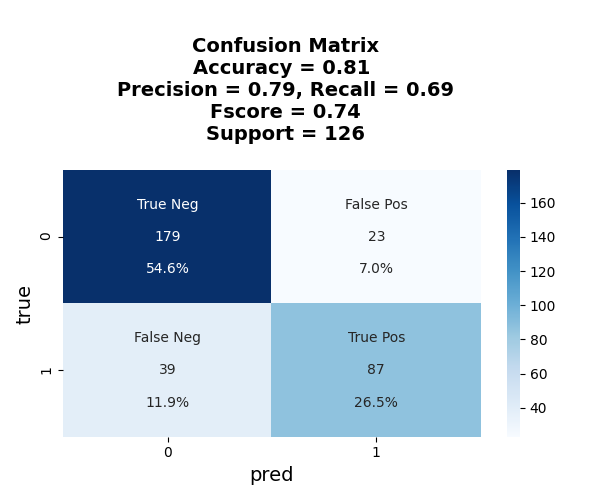

In [62]:
Image(filename='data_dir/artifacts/sagemaker_model_artifacts/model_cm_plot.png')

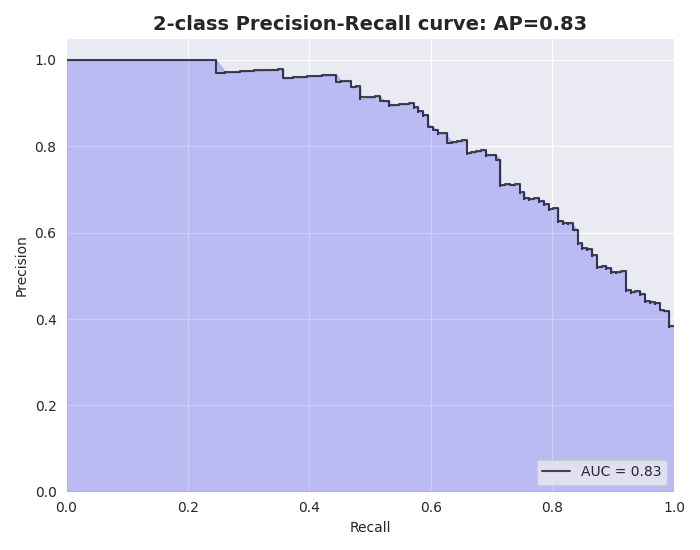

In [63]:
Image(filename='data_dir/artifacts/sagemaker_model_artifacts/model_pr_curve_plot.png')

In [64]:
import joblib
from sklearn import set_config
from sklearn.pipeline import Pipeline

In [65]:
path_pp_model = "data_dir/artifacts/sagemaker_pp_artifacts/model.joblib"
path_ml_model = "data_dir/artifacts/sagemaker_model_artifacts/model.joblib"

# these are the models extracted from PP_MODEL annd ML_MODEL containers
pp_model = joblib.load(path_pp_model)
ml_model = joblib.load(path_ml_model)

# current ml-pipeline structure
clf_model = Pipeline(steps=[('preprocessor', pp_model),
                      ('classifier', ml_model)])
set_config(display='diagram')
clf_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])],
                                   verbose=True)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2, n_jobs=-1))])

## 2. Model Interpretation (SHAP)

## Get pre-processed data
1. batch transform the raw_test --> pp_test data using trained sklearn_preprocessor model
2. fetch the transformed pre-processsed data from S3 bucket

In [66]:
colList_ML = ['age', 'fare', 'embarked_C', 'embarked_Q', 'embarked_S', 'gender_female', 'gender_male', 
              'pclass_1', 'pclass_2', 'pclass_3']
colList =[col_to_predict, "user_id"] + colList_ML

In [69]:
# fetch the pp datato local dir generated from batch job results
s3uri     = s3_pp_test
file_name = '{}.out'.format(RAW_TEST_PATH.split("/")[-1])
s3_obj = get_csv_output_from_s3(s3uri, file_name)
df_pp  = pd.read_csv(io.StringIO(s3_obj), sep=",", header=None)

#df_pp = df_pp.drop(columns=[0,1])
df_pp.columns = colList

sagemaker-us-east-1-120286446822
sagemaker-scikit-learn-2020-09-24-07-31-03-605
test_titanic_dataset.csv.out


In [70]:
print(df_pp.shape)
df_pp.head(7)

(328, 12)


,survived,user_id,age,fare,embarked_C,embarked_Q,embarked_S,gender_female,gender_male,pclass_1,pclass_2,pclass_3
0,0,user_1132,-0.118065,-0.509837,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,user_245,0.277008,1.121465,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0,user_1298,0.514052,-0.476545,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0,user_426,0.039964,-0.403908,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0,user_861,-0.513137,-0.509231,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5,0,user_1306,-0.236587,-0.523759,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,1,user_481,-0.592152,0.189207,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## SHAP - overall ML model performance

In [71]:
def shap_force_plot(instance_id=None, X=None, shap_explainer=None, ml_model=None, class_index=None, colList_ML=None):
    choosen_instance = X.loc[X["user_id"]==instance_id][colList_ML]

    pred_score = round(ml_model.predict_proba(choosen_instance)[0][class_index], 2)
    shap_values = shap_explainer.shap_values(choosen_instance)
    print("model_pred_score : {}".format(pred_score))

    f = shap.force_plot(shap_explainer.expected_value[class_index], shap_values[class_index], choosen_instance)
    return f

In [74]:
#!pip install shap

In [75]:
import shap
shap.initjs()

In [76]:
class_index = 1 # i.e predicting "if survived"

In [77]:
model = ml_model
X = df_pp.copy()
shap_explainer = shap.TreeExplainer(model)

### individual data point prediction insights

In [78]:
instance_id = "user_861" # true : 0
shap_force_plot(instance_id=instance_id, X=X, shap_explainer=shap_explainer, ml_model=ml_model, 
                class_index=class_index, colList_ML=colList_ML)

model_pred_score : 0.67


In [79]:
instance_id = "user_245" # true : 1
shap_force_plot(instance_id=instance_id, X=X, shap_explainer=shap_explainer, ml_model=ml_model, 
                class_index=class_index, colList_ML=colList_ML)

model_pred_score : 1.0


In [80]:
instance_id = "user_1306" # true : 0
shap_force_plot(instance_id=instance_id, X=X, shap_explainer=shap_explainer, ml_model=ml_model, 
                class_index=class_index, colList_ML=colList_ML)

model_pred_score : 0.12


### summarized force plot

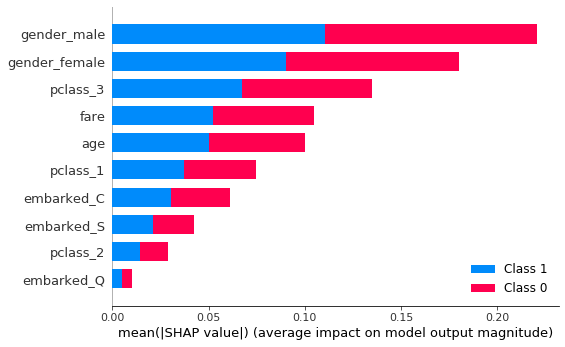

In [81]:
#"dot" (default for single output), "bar" (default for multi-output), "violin",
#    or "compact_dot".
    
X = df_pp[colList_ML]

shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [82]:
shap.force_plot(shap_explainer.expected_value[class_index], shap_values[class_index][:1000,:], X.iloc[:1000,:])

### Summary plot

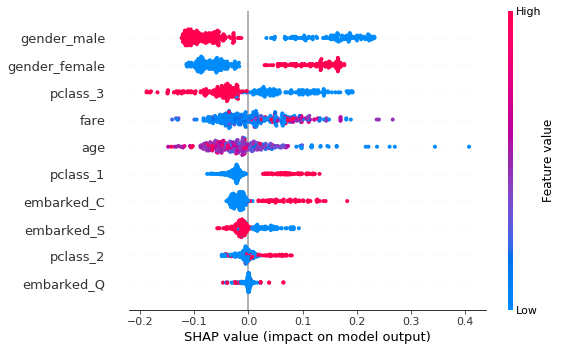

In [83]:
shap.summary_plot(shap_values[class_index], X, plot_type="dot")

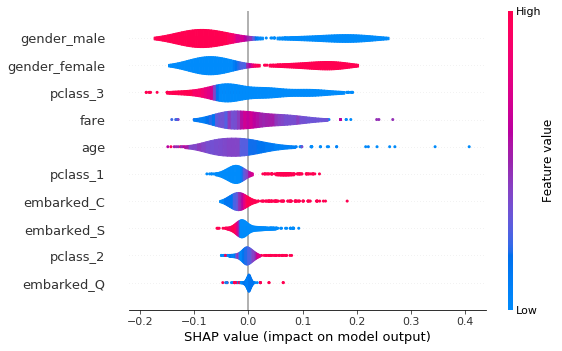

In [84]:
shap.summary_plot(shap_values[class_index], X, plot_type="violin")

### individual feature analysis

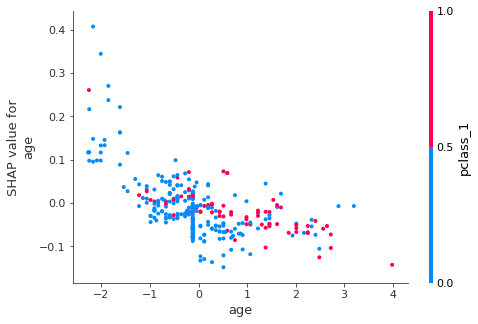

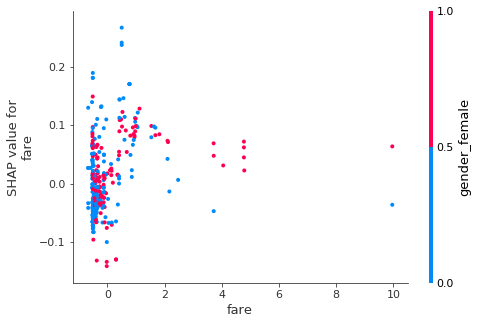

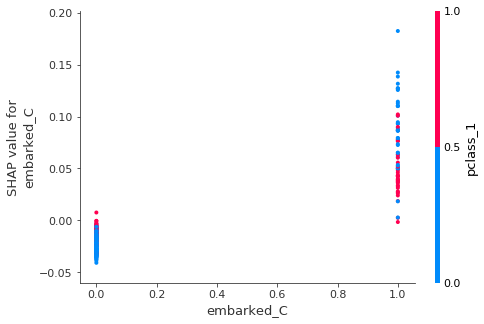

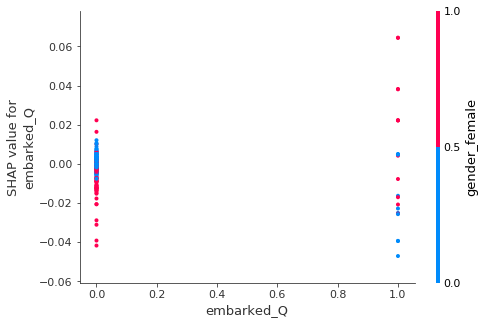

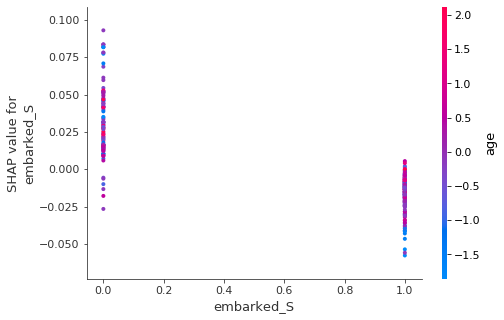

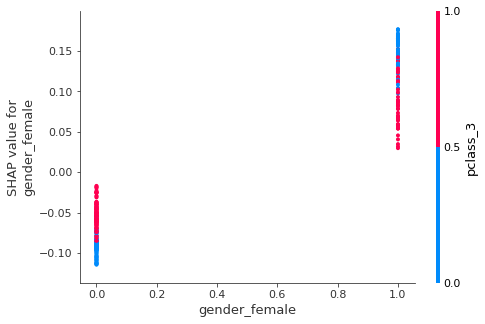

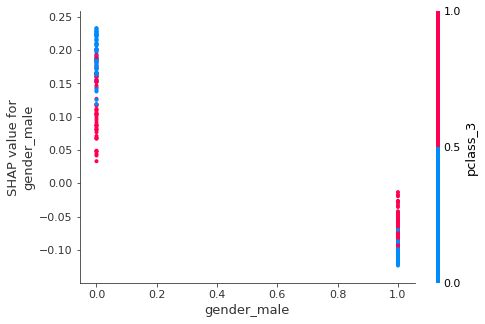

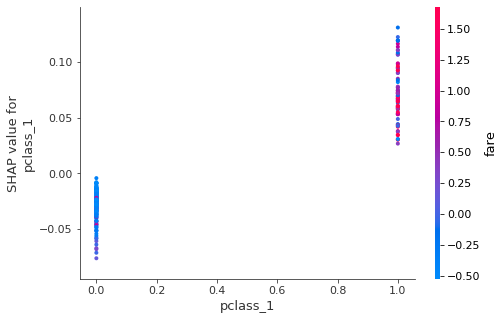

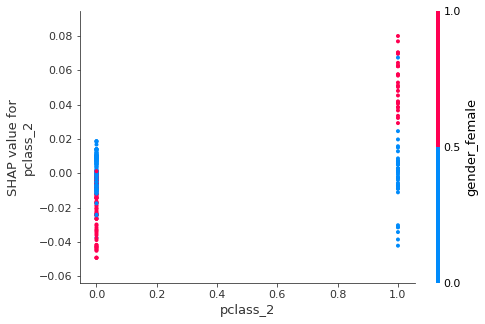

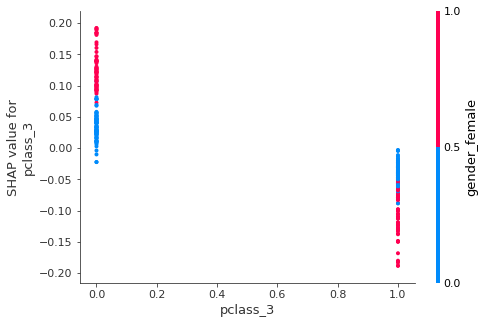

In [85]:
for name in colList_ML:
    shap.dependence_plot(name, shap_values[class_index], X, display_features=X)

In [ ]:
stop

## Delete Endpoint <a class="anchor" id="delete_endpoint"></a>
Once we are finished with the endpoint, we clean up the resources!

In [ ]:
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)